In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def GetImg(path):
  test_img = Image.open(path)
  test_img = test_img.resize((16, 16))
  plt.subplot(5, 5, i)
  plt.imshow(test_img, cmap = "gray")
  test_img = test_img.convert('1')
  test_x = np.array(test_img, np.float32)
  test_x = test_x.reshape([-1, 256])
  return test_x

In [ ]:
def reverse(array):
  revArr = []
  for x in array:
    revX = []
    for xi in x:
      if (xi == 1.0):
        revX.append(0)
      else:
        revX.append(1)
    revArr.append(revX)
  return revArr

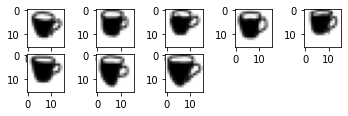

In [ ]:
x_train = []
y_train = []
  
path = '/content/drive/My Drive/Cup/'
for i in range(1, 9):
  x_train.append(GetImg(path + str(i) +'.png')[0])
  y_train.append(1)

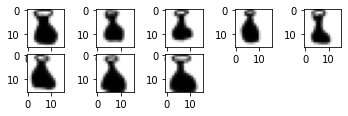

In [ ]:
path = '/content/drive/My Drive/Bottle/'
for i in range(1, 9):
  x_train.append(GetImg(path + str(i) +'.png')[0])
  y_train.append(0)

In [ ]:
x_train = reverse(x_train)

In [ ]:
def step_func(x):
  if(x > 0):
    return 1
  else:
    return 0

In [ ]:
def Sigmoid(s):
  return 1 / (1 + np.exp(-s))

def SigmDer(s):
  return Sigmoid(s) * (1 - Sigmoid(s))

def ErrAcc(pred_y, tst_y, eps):
  hit = 0
  for i in range(len(tst_y)):
    if(np.abs(pred_y[i] - tst_y[i]) < eps): hit = hit + 1
  return hit / len(tst_y)

def ErrLoss(pred_y, tst_y):
  loss = 0
  for i in range(len(tst_y)):
    loss += np.square(pred_y[i] - tst_y[i])
  loss = np.sqrt(loss) / len(tst_y)
  return loss

In [ ]:
class Neuron:
  def __init__(self, weightsCount, number = None):
    if number is None: 
      self.weights = []
      for i in range(weightsCount):
        self.weights.append(np.random.normal() * 3)
      self.bias = np.random.normal() * 3
    else:
      self.weights = [] 
      for i in range(weightsCount):
        self.weights.append(number)
      self.bias = number

  def GetSum(self, x):
    sum = self.bias
    for i in range(len(self.weights)):
      sum += self.weights[i] * x[i]
    return sum

  def Feed(self, x):
    return Sigmoid(self.GetSum(x))

class Network:
  def __init__(self, x_count):
    self.NeuronsL1 = []
    self.NeuronsL2 = []
    self.NeuronsL3 = Neuron(15)
    for i in range(30):
      self.NeuronsL1.append(Neuron(x_count))
    for i in range(15):
      self.NeuronsL2.append(Neuron(30))

  def Predict(self, data):
    y_pred = []
    for x in data:
      res1 = []
      for n in self.NeuronsL1:
        res1.append(n.Feed(x))
      res2 = []
      for n in self.NeuronsL2:
        res2.append(n.Feed(res1))
      y_pred.append(self.NeuronsL3.Feed(res2))
    return y_pred

  def TrainGrad(self, data, y_trues, speed, epochs):
    errs = []
    epchs = []
    for epoch in range(epochs):
      for x, y_true in zip(data, y_trues):
        self.GradIteration(x, y_true, speed)
      if epoch % 10 == 0:
        y_preds = self.Predict(data)
        err = ErrLoss(y_trues, y_preds)
        acc = ErrAcc(y_trues, y_preds, 0.1)
        epchs.append(epoch)
        errs.append(err)
        print("Epoch %d err: %.3f" % (epoch, err))
        print("Epoch %d acc: %.3f" % (epoch, acc))
    return epchs, errs

  def GradIteration(self, x, y_true, speed):
    res1 = []
    for n in self.NeuronsL1:
      res1.append(n.Feed(x))
    res2 = []
    for n in self.NeuronsL2:
      res2.append(n.Feed(res1))
    out = self.NeuronsL3.Feed(res2)
    delta = out - y_true
    grad = delta * SigmDer(out)
    for i in range(len(res2)):
      self.NeuronsL3.weights[i] -= speed * grad * res2[i]
    self.NeuronsL3.bias -= speed * grad
    grad2 = []
    for i in range(len(res2)):
      grad2.append(grad * self.NeuronsL3.weights[i] * SigmDer(res2[i]))
    grad2_bias = grad * self.NeuronsL3.bias * SigmDer(1)
    for i in range(len(self.NeuronsL2)):
      for j in range(len(res1)):
        self.NeuronsL2[i].weights[j] -= speed * grad2[i] * res1[j]
      self.NeuronsL2[i].bias -= speed * grad2_bias
    grad1 = []
    for i in range(len(res1)):
      grad_sum = 0
      for j in range(len(self.NeuronsL2)):
        grad_sum += grad2[j] * self.NeuronsL2[j].weights[i] * SigmDer(res1[i])
      grad1.append(grad_sum)
    grad1_bias = 0
    for j in range(len(self.NeuronsL2)):
      grad1_bias += grad2[j] * self.NeuronsL2[j].bias * SigmDer(1)
    for i in range(len(self.NeuronsL1)):
      for j in range(len(x)):
        self.NeuronsL1[i].weights[j] -= speed * grad1[i] * x[j]
      self.NeuronsL1[i].bias -= speed * grad1_bias

In [ ]:
network = Network(256)
epochs, errors = network.TrainGrad(x_train, y_train, 1, 100)

Epoch 0 err: 0.177
Epoch 0 acc: 0.500
Epoch 10 err: 0.001
Epoch 10 acc: 1.000
Epoch 20 err: 0.001
Epoch 20 acc: 1.000
Epoch 30 err: 0.001
Epoch 30 acc: 1.000
Epoch 40 err: 0.001
Epoch 40 acc: 1.000
Epoch 50 err: 0.001
Epoch 50 acc: 1.000
Epoch 60 err: 0.000
Epoch 60 acc: 1.000
Epoch 70 err: 0.000
Epoch 70 acc: 1.000
Epoch 80 err: 0.000
Epoch 80 acc: 1.000
Epoch 90 err: 0.000
Epoch 90 acc: 1.000


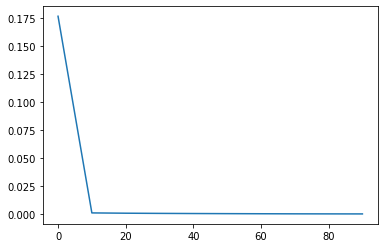

In [ ]:
plt.plot(epochs, errors)
plt.show()

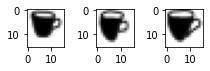

In [ ]:
x_test = []
y_test = []
path = '/content/drive/My Drive/Cup/'
for i in range(6, 9):
  x_test.append(GetImg(path + str(i) +'.png')[0])
  y_test.append(1)

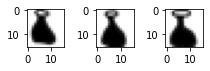

In [ ]:
path = '/content/drive/My Drive/Bottle/'
for i in range(6, 9):
  x_test.append(GetImg(path + str(i) +'.png')[0])
  y_test.append(0)

In [ ]:
x_test = reverse(x_test)

In [ ]:
def get_res(y):
  if y > 0.5:
    return 1
  return 0

acc:0.0


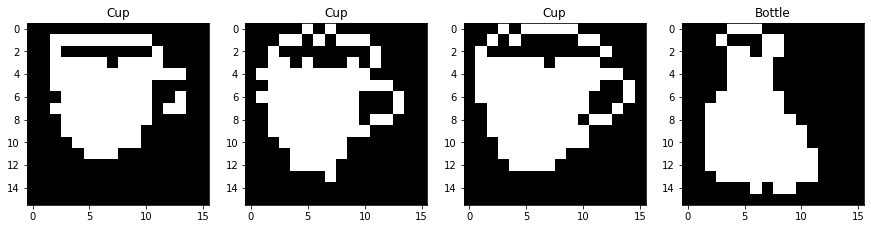

In [ ]:
y_pred = network.Predict(x_test)
y_pred_binary = []
for i in range(len(y_pred)):
  y_pred_binary.append(get_res(y_pred[i])) 
acc = ErrAcc(y_test, y_pred_binary, 0.1)
print("acc:" + str(acc))
ress = ['Bottle', 'Cup']
plt.figure(figsize=(15,5))
for i in range(4):
  plt.subplot(1, 4, i + 1)
  plt.title(ress[get_res(y_pred[i])])
  img = np.reshape((x_test[i]), [16, 16])
  plt.imshow(img, cmap="gray")